In [13]:
from pathlib import Path
import sys, importlib
import pandas as pd
sys.path.insert(0, str(Path("..").resolve())) 

import src.data.itch as itch                     
importlib.reload(itch)         
                    
from src.data.itch import load_lobster_top1_day

root = Path("../data/raw/itch/AAPL")
df_itch = load_lobster_top1_day(root, "AAPL")  


SCALE = 10_000.0  
q = pd.DataFrame({
    "time":     df_itch["time"].values,
    "bid$":     df_itch["bid"].values     / SCALE,
    "ask$":     df_itch["ask"].values     / SCALE,
    "mid$":     df_itch["mid"].values     / SCALE,
    "spread$":  df_itch["spread"].values  / SCALE,
    "bid_size": df_itch["bid_size"].values,
    "ask_size": df_itch["ask_size"].values,
})

print(q.head(), q.shape)

           time    bid$    ask$     mid$  spread$  bid_size  ask_size
0  34200.004241  585.33  585.94  585.635     0.61      18.0     200.0
1  34200.004261  585.33  585.94  585.635     0.61      18.0     200.0
2  34200.004447  585.33  585.94  585.635     0.61      18.0     200.0
3  34200.025552  585.33  585.91  585.620     0.58      18.0      18.0
4  34200.025580  585.33  585.91  585.620     0.58      18.0      18.0 (400391, 7)


In [14]:
from pathlib import Path
import pandas as pd

root = Path("../data/raw/itch/AAPL")
q = q[["time","bid$","ask$","mid$"]].rename(columns={"bid$":"bid","ask$":"ask","mid$":"mid"}).reset_index(drop=True)

X = pd.DataFrame({
    "imb": (q["bid"] - q["ask"]) / (q["bid"] + q["ask"]),
    "spread": (q["ask"] - q["bid"]),
}).fillna(0.0)

h = 5
y = (q["mid"].shift(-h) > q["mid"]).astype(int).fillna(0).astype(int)


In [18]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np


Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

rf = RandomForestClassifier(
    n_estimators=300, max_depth=6, random_state=0, n_jobs=-1
)
rf.fit(Xtr, ytr)

proba_te = rf.predict_proba(Xte)[:,1]
print("AUC (holdout):", roc_auc_score(yte, proba_te))


tscv = TimeSeriesSplit(n_splits=5)
aucs = []
for tr, te in tscv.split(X):
    aucs.append(roc_auc_score(y.iloc[te], rf.fit(X.iloc[tr], y.iloc[tr]).predict_proba(X.iloc[te])[:,1]))
print("AUCs:", aucs, " | mean:", np.mean(aucs))

p_up = rf.predict_proba(X)[:,1]

qshare = np.clip( (p_up - 0.5) * 4.0, 0.0, 1.0 )

mask = (q["time"] >= q["time"].iloc[0]) & (q["time"] <= q["time"].iloc[0] + 60*60)
q_sim   = q.loc[mask].reset_index(drop=True)
qshare_sim = qshare[mask]

AUC (holdout): 0.5227219934810212
AUCs: [0.5165757869789973, 0.5249180213386443, 0.5205643073076496, 0.5146901369240218, 0.5108673053323123]  | mean: 0.5175231115763251


In [19]:
import pandas as pd
import numpy as np

def per_second_targets_by_share(qshare, n_secs, Q_total):
    base = Q_total // n_secs
    rem  = int(Q_total - base*n_secs)
    t = np.full(n_secs, base, dtype=float)

    w = qshare[:n_secs].astype(float)
    w = np.maximum(w, 1e-6)
    w /= w.sum()
    t = (Q_total * w).astype(int)

    if t.sum() < Q_total:          
        t[:(Q_total - t.sum())] += 1
    return pd.Series(t)

n_secs = len(q_sim)
Q_total = 50_000   
targets = per_second_targets_by_share(qshare_sim, n_secs, Q_total)


In [20]:
q_sim = q[["bid","ask","mid"]].copy()
q_sim.index.name = "time"

In [21]:
import numpy as np
import pandas as pd

def per_second_targets(Q: float, n_secs: int) -> pd.Series:
    base = int(Q)
    rem = Q - base
    t = np.full(n_secs, base, dtype=float)
    if rem > 0:
        t[:1] += 1  # sprinkle remainder (keep it simple)
    return pd.Series(t, index=q_sim.index[:n_secs])

n_secs = min(len(q_sim), 3000)   # simulate first 3000 seconds as an example
targets = per_second_targets(Q=1.0, n_secs=n_secs)


In [22]:
q_sim = df_itch[["time", "bid", "ask", "mid", "bid_size", "ask_size"]].copy()
q_sim.index.name = None 

n_secs = min(len(q_sim), 3000)
targets = per_second_targets(Q=1.0, n_secs=n_secs)

from importlib import reload
import src.execution.simulator as sim
reload(sim)

fills_agg = sim.simulate_aggressive(q_sim.loc[targets.index], targets, cap_frac=0.25)
fills_pas = sim.simulate_passive_then_flip(q_sim.loc[targets.index], targets, timeout_secs=5, cap_frac=0.25)



In [23]:
import importlib, inspect
import src.execution.simulator as sim
importlib.reload(sim)  

print("simulate_aggressive:", inspect.signature(sim.simulate_aggressive))
print("simulate_passive_then_flip:", inspect.signature(sim.simulate_passive_then_flip))


simulate_aggressive: (df, targets, cap_frac=0.2)
simulate_passive_then_flip: (df, targets, timeout_secs=5, cap_frac=0.2, queue_share=0.25)


In [25]:
import numpy as np
import pandas as pd


scale = 10_000
book = df_itch.copy()
book["bid"]  = book["bid"]  / scale
book["ask"]  = book["ask"]  / scale
book["mid"]  = book["mid"]  / scale
book["spread$"] = book["ask"] - book["bid"]


book_sec = (
    book.set_index(pd.to_timedelta(book["time"], unit="s"))
        .resample("1S").last().dropna()
        .reset_index(drop=True)
)


q_sec = book_sec[["time", "bid", "ask", "bid_size", "ask_size", "mid"]].copy()
q_sec["time"] = q_sec.index.astype(float)  


def per_second_targets(qty_total, n_secs):
    base = qty_total // n_secs
    rem  = qty_total %  n_secs
    t = np.full(n_secs, base, dtype=int)
    if rem > 0:
        t[:rem] += 1
    return pd.Series(t, index=np.arange(n_secs), name="target")

Q = 10_000                   
targets = per_second_targets(Q, len(q_sec))


from importlib import reload
import src.execution.simulator as sim
reload(sim)

fills_agg = sim.simulate_aggressive(q_sec, targets, cap_frac=0.2)
fills_pas = sim.simulate_passive_then_flip(q_sec, targets, timeout_secs=2, cap_frac=0.2, queue_share=0.25)


from src.eval.metrics import score_metrics
summary = pd.DataFrame([
    {"Strategy": "Aggressive",       **score_metrics(fills_agg, q_sec)},
    {"Strategy": "PassiveThenFlip",  **score_metrics(fills_pas, q_sec)}
])
summary


/var/folders/xx/w12875ds6blcc9p0ljq82tdw0000gn/T/ipykernel_32089/2350573959.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample("1S").last().dropna()


,Strategy,fills,fill_rate,CPS,SpreadCapture%,PTM@5s
0,Aggressive,10000,100.0,8.805704,0.000,-0.191873
1,PassiveThenFlip,10542,100.0,-8.231075,96.807,-0.127835


In [26]:
import numpy as np
import pandas as pd
rows = []
for tout in [1, 2, 3, 5]:
    for cap in [0.1, 0.2, 0.3]:
        for qshare in [0.1, 0.25, 0.5]:
            f_pas = sim.simulate_passive_then_flip(q_sec, targets, timeout_secs=tout, cap_frac=cap, queue_share=qshare)
            rows.append({"timeout": tout, "cap": cap, "qshare": qshare,
                         **score_metrics(f_pas, q_sec)})
pd.DataFrame(rows).sort_values("CPS", ascending=False).head(10)


,timeout,cap,qshare,fills,fill_rate,CPS,SpreadCapture%,PTM@5s
33,5,0.3,0.1,10891,100.0,-7.786575,94.362,-0.12909
6,1,0.3,0.1,10891,100.0,-7.786575,94.362,-0.12909
24,3,0.3,0.1,10891,100.0,-7.786575,94.362,-0.12909
15,2,0.3,0.1,10891,100.0,-7.786575,94.362,-0.12909
12,2,0.2,0.1,10891,100.0,-7.791460,94.389,-0.12729
3,1,0.2,0.1,10891,100.0,-7.791460,94.389,-0.12729
30,5,0.2,0.1,10891,100.0,-7.791460,94.389,-0.12729
21,3,0.2,0.1,10891,100.0,-7.791460,94.389,-0.12729
0,1,0.1,0.1,10891,100.0,-7.800620,94.449,-0.12574
27,5,0.1,0.1,10891,100.0,-7.800620,94.449,-0.12574


<Axes: >

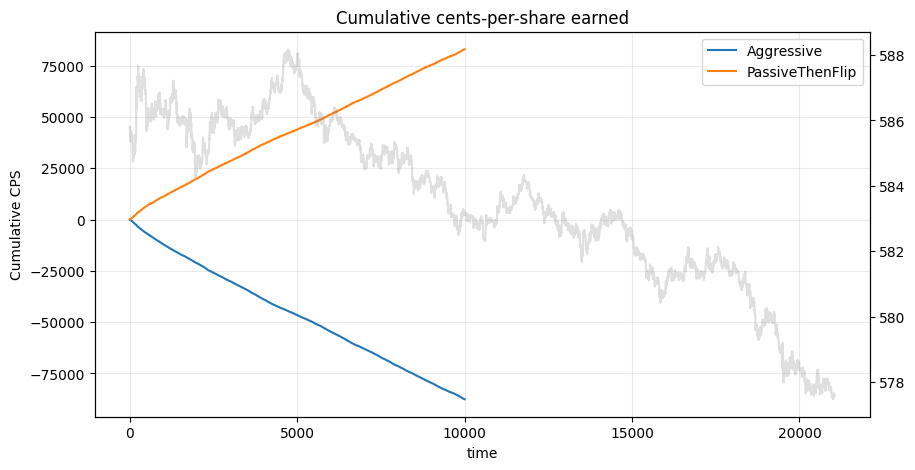

In [34]:
import matplotlib.pyplot as plt

def _col(df, *candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in columns {list(df.columns)}")

def add_cents_per_share(fills: pd.DataFrame, book: pd.DataFrame, side: int = +1):
    price_col = _col(fills, "price", "px")
    mid_col   = _col(book,  "mid$", "mid")

    j = fills.join(book.set_index("time")[[mid_col]], on="time", how="left")
    j["cents"] = (j[mid_col] - j[price_col]) * 100.0 * side
    return j

def cum_cps(fills_with_cents: pd.DataFrame):
    return fills_with_cents.set_index("time")["cents"].cumsum()


f_agg_c = add_cents_per_share(fills_agg, q_sec, side=+1)
f_pas_c = add_cents_per_share(fills_pas, q_sec, side=+1)


fig, ax = plt.subplots(figsize=(10,5))
cum_cps(f_agg_c).plot(ax=ax, label="Aggressive")
cum_cps(f_pas_c).plot(ax=ax, label="PassiveThenFlip")
ax.set_title("Cumulative cents-per-share earned")
ax.set_ylabel("Cumulative CPS")
ax.legend()
ax.grid(True, alpha=0.25)


mid_col = "mid$" if "mid$" in q_sec.columns else "mid"
q_sec.set_index("time")[mid_col].plot(ax=ax, secondary_y=True, alpha=0.25, color="gray")


In [32]:
from pathlib import Path

out_dir = Path("data/results")
out_dir.mkdir(parents=True, exist_ok=True)   # make data/results if it isn't there

out_path = out_dir / "aapl_2012-06-21_baselines.csv"
summary.to_csv(out_path, index=False)
print("saved ->", out_path.resolve())

saved -> /Users/krithiktoure/Desktop/DS Project 2/exec-engine/notebooks/data/results/aapl_2012-06-21_baselines.csv
